## Traitement des données

Vous retrouverez en bas de ce notebook un wordcloud des articles les plus vendus au PIC'asso.

Ce notebook a deux objectifs :
1. Supprimer les points de vente qui ne concernent pas les données du pic 
2. Traitement des Familles d'articles :
    + Imputer les données manquantes pour les familles d'articles
    + Suppression des familles d'articles trop peu présentes pour être pertinentes
    + Suppression des familles d'articles qui ne correspondent pas à des ventes du pic
    + Fusion des familles d'articles ayant la même signification
3. Traitement des articles

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_folder = os.path.join(os.getcwd(), '../data_original')
df = pd.read_csv(os.path.join(data_folder, 'merged_data.csv'), sep=',')
nombre_donnees_initial = df.shape[0]

C:\Users\marti\AppData\Local\Temp\ipykernel_21080\575796113.py:2: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_folder, 'merged_data.csv'), sep=',')


In [32]:
df.head(3)

,Date/heure transaction,ID acheteur,Nom point de vente,Article,Famille d'article,Prix unitaire TTC,Quantité,Total TTC,Activité
0,2017-05-02 09:28:04.913,15228,Pic journée,Formule Tit Dej,Viennoiserie,1.0,1.0,1.0,NaN
1,2017-05-02 09:32:57.699,11678,Pic journée,Thé lipton,Viennoiserie,0.1,1.0,0.1,NaN
2,2017-05-02 09:37:13.780,11150,Pic journée,Café,Café & Thé,0.4,1.0,0.4,NaN


# 1. Suppression des points de vente qui ne concernent pas les données du pic

Nous avions déjà vu que la colonne des points de vente comportait des valeurs manquantes. On va les remplacer dans un premier temps par "PIC"

In [33]:
df['Nom point de vente'].fillna('Pic', inplace=True)

On affiche ensuite la proportion de chaque point de vente.

<Axes: xlabel='Nom point de vente'>

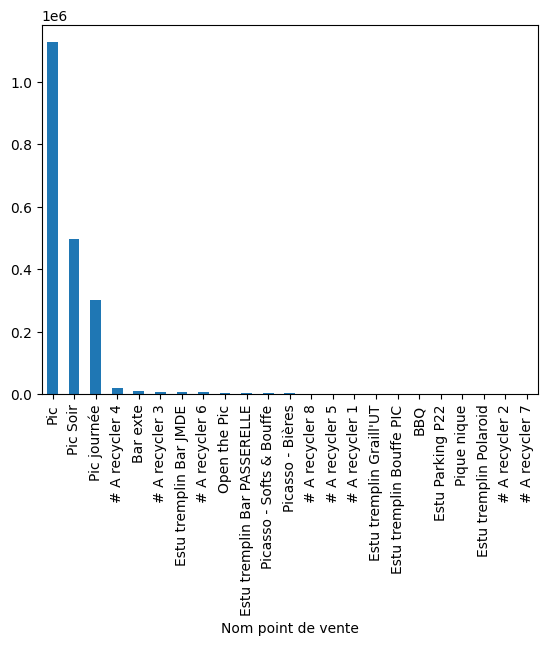

In [34]:
df["Nom point de vente"].value_counts().plot(kind='bar')

On voit qu'on a beaucoup de valeurs manquantes pour le point de vente. En dehors des valeurs manquantes, "Pic Soir" et "Pic journée" sont les deux points de vente les plus représentés.

Les catégories "Pic journée", "Pic Soir", "Open the Pic", "Picasso - Softs & Bouffe" et "Picasso - Bières" sont assez explicites. On va donc les conserver, en plus de des "NaN", au vu de la quantité qu'ils représentent, on ne peut pas les exclure tels quels.

On va donc comparer les familles d'articles présentes dans ces points de référence avec les familles d'articles présentes dans les autres points de vente. pour voir s'il y a quelque chose à en tirer.

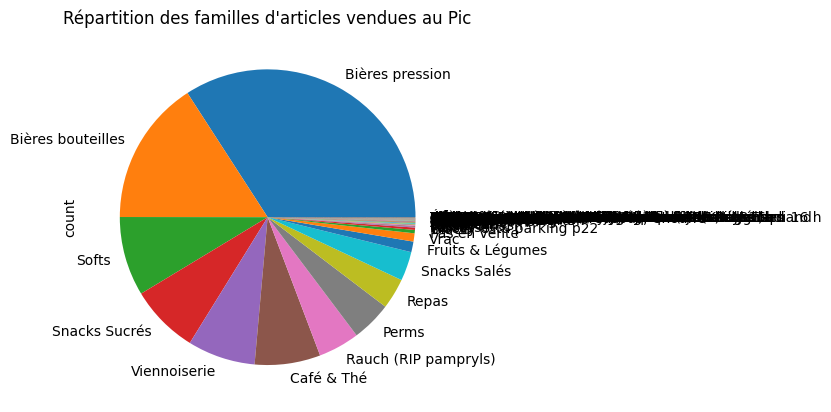

In [35]:
# On commence par afficher les familles d'articles vendues au Pic
points_pic = ["Pic journée", "Pic Soir", "Open the Pic", "Picasso - Softs & Bouffe", "Picasso - Bières", "Pic"]
liste_articles = df[df["Nom point de vente"].isin(points_pic)]["Famille d'article"]
liste_articles.value_counts().plot.pie()
plt.title("Répartition des familles d'articles vendues au Pic")
plt.show()


Nous constatons que ces familles d'articles sont cohérentes avec ce qui est vendu au pic.

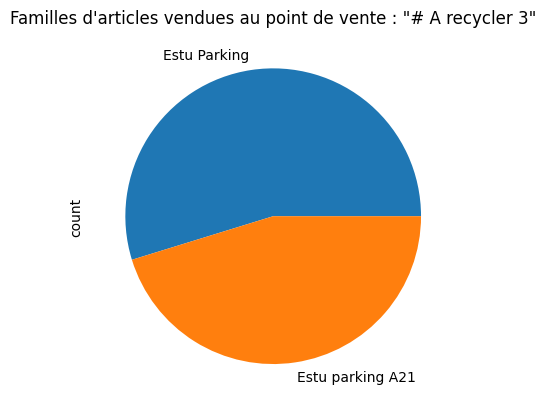

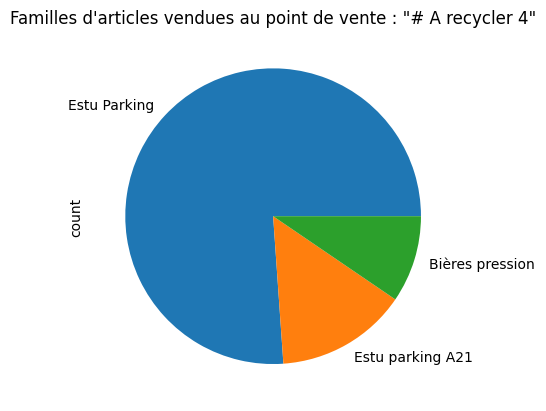

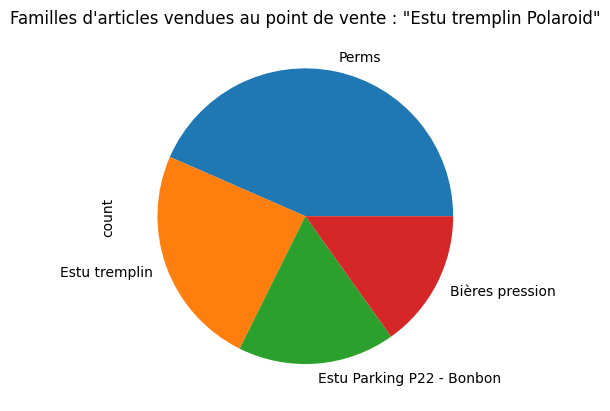

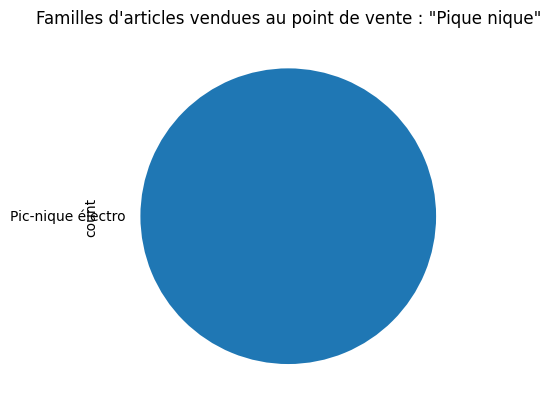

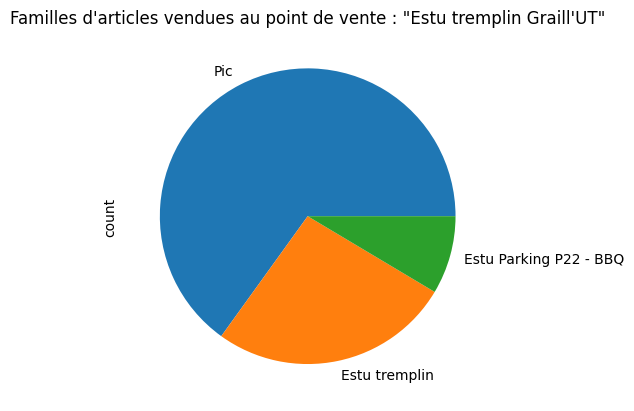

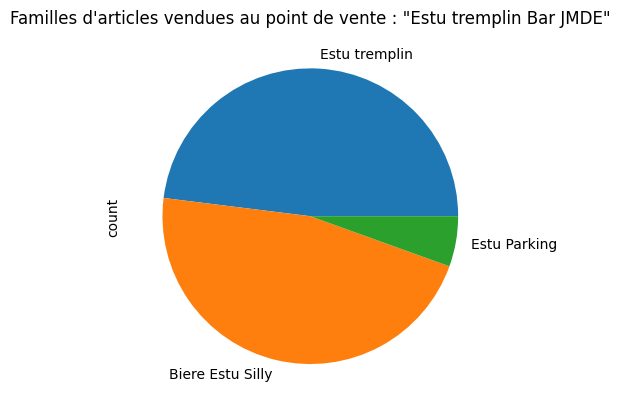

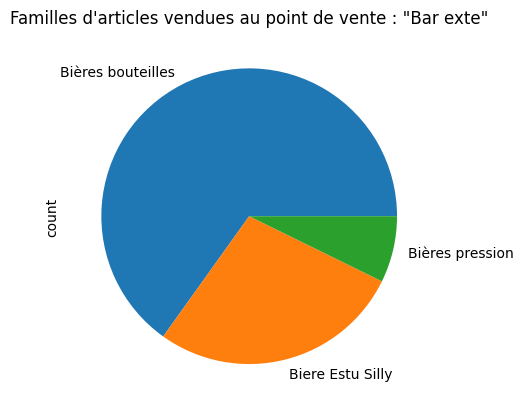

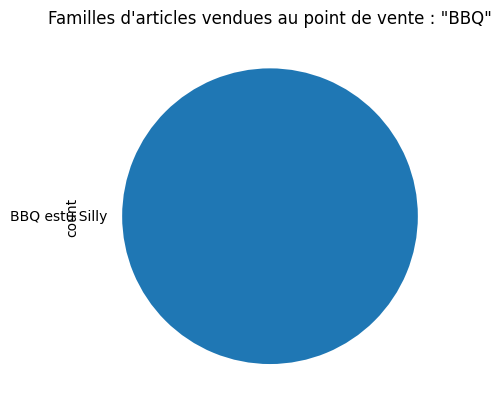

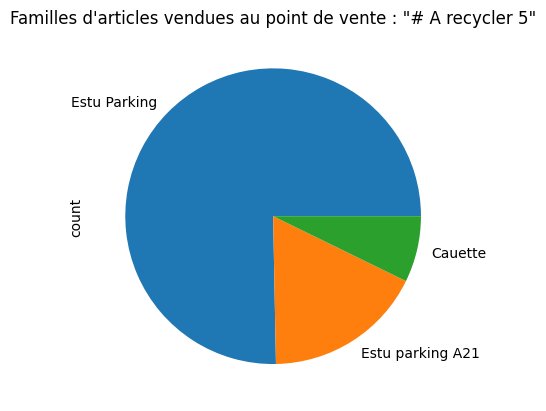

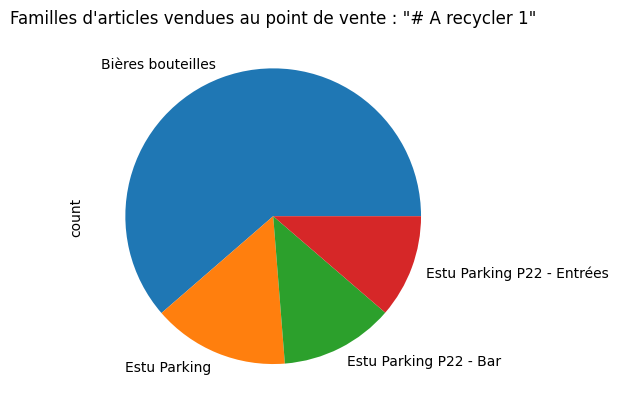

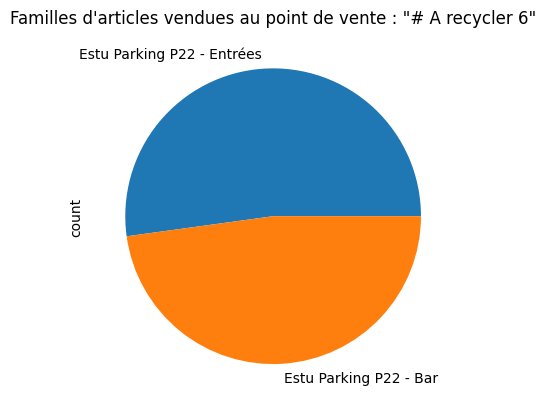

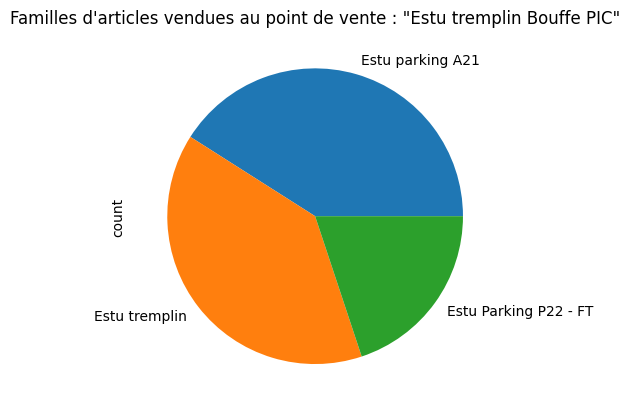

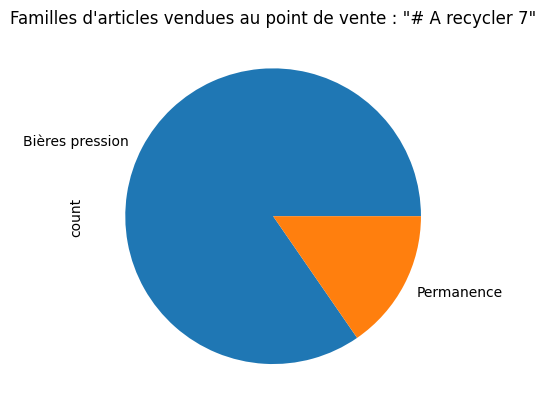

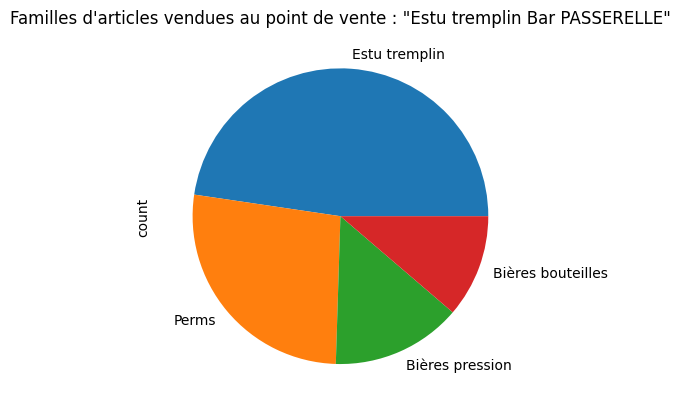

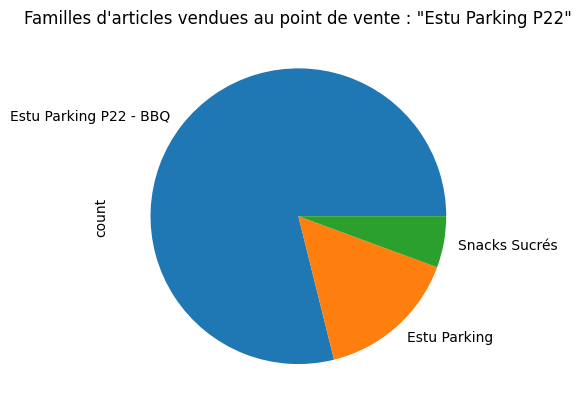

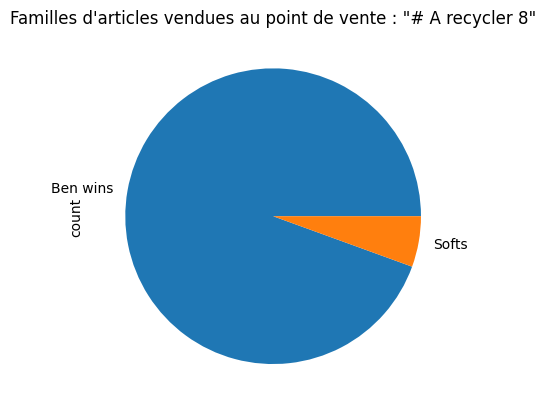

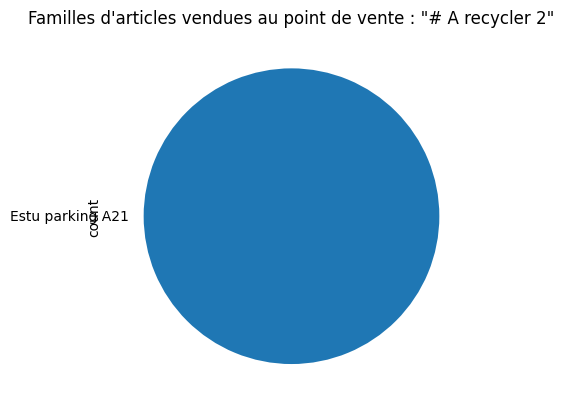

In [36]:
liste_pdv = df["Nom point de vente"].unique()
liste_pdv = np.delete(liste_pdv, np.where(np.isin(liste_pdv, points_pic)))

for pdv in liste_pdv:
    df_pdv = df[df["Nom point de vente"] == pdv]["Famille d'article"]
    n_pdv = df_pdv.shape[0]
    df_pdv = df_pdv.value_counts()
    df_pdv = df_pdv[df_pdv / n_pdv * 100 > 5]
    df_pdv.plot.pie()
    plt.title(f"Familles d'articles vendues au point de vente : \"{pdv}\"")
    plt.show()

Tous ces points de ventes contiennent majoritairement si ce n'est totalement des articles qui n'ont rien à voir avec ce qui est vendu au Pic. De plus ces point de ventes concernent pour la plupart des évènements, et on peut supposer que les habitudes de consommation changent lors d'évènements. On va donc supprimer ces points de vente.

Les points de vente que nous conservons sont donc "Pic journée", "Pic Soir", "Open the Pic", "Picasso - Softs & Bouffe", "Picasso - Bières", plus les valeurs manquantes NaN que nous avons transformées en "Pic".

In [37]:
n_before = df.shape[0]
df = df[df['Nom point de vente'].str.contains('Pic')]
n_after = df.shape[0]

print(f"Il reste {n_after/n_before*100:.2f}% des données par rapport à l'étape d'avant après suppression des points de vente non pertinents.")

Il reste 96.93% des données par rapport à l'étape d'avant après suppression des points de vente non pertinents.


# 2. Traitement des Familles d'articles

## 2.1 Imputation des données manquantes

On commence par afficher les lignes avec les données manquantes pour les famille d'article.

In [38]:
df_missing = df[df["Famille d'article"].isna()]
df_missing['Article'].value_counts()

Article
Pampryl Tomate     50
petit dej rugby    34
Name: count, dtype: int64

On peut voir que les données avec la famille d'article manquante sont des jus de tomate, ou des "petit dej rugby". Pour le premier il suffit de mettre la meme famille que les autres jus, tandis que l'autre fait partie des familles que l'on veut éliminer ne se vend pas au PIC

In [39]:
nom_famille = df[df["Article"] == "PAMPRYL Fraise"]["Famille d'article"].unique()[0]
print("Les jus sont de la famille : ", nom_famille)

# On fixe la categorie de ceux qui ont "Pampryl Tomate" comme article
df.loc[df["Article"] == "Pampryl Tomate", "Famille d'article"] = nom_famille

# On fixe la categorie de ceux qui ont "petit dej rugby" comme article
# Ces lignes seront supprimées par la suite, mais fixer une valeur permet de se débarasser des valeurs manquantes
df.loc[df["Article"] == "petit dej rugby", "Famille d'article"] = "dej"

df_missing = df[df["Famille d'article"].isna()]
df_missing['Article'].value_counts()

Les jus sont de la famille :  Rauch (RIP pampryls)


Series([], Name: count, dtype: int64)

Il n'y a plus de valeurs manquantes pour les familles d'articles.

## 1.2.
+ Suppression des familles d'articles trop peu présentes pour être pertinentes
+ Suppression des familles d'articles qui ne correspondent pas à des ventes du pic
+ Fusion des familles d'articles ayant la même signification

On commence par une observation générale des famille d'articles.

Nombre de familles d'articles :  147

Decompte par valeur : 

Famille d'article
Bières pression                                    659677
Bières bouteilles                                  306303
Softs                                              167555
Snacks Sucrés                                      145527
Viennoiserie                                       143213
                                                    ...  
Dégustation Val Dieu                                    1
test                                                    1
Dégustation de Mercredi 14h - Brasserie Du Bocq         1
Poulet                                                  1
Biere Estu Silly                                        1
Name: count, Length: 147, dtype: int64


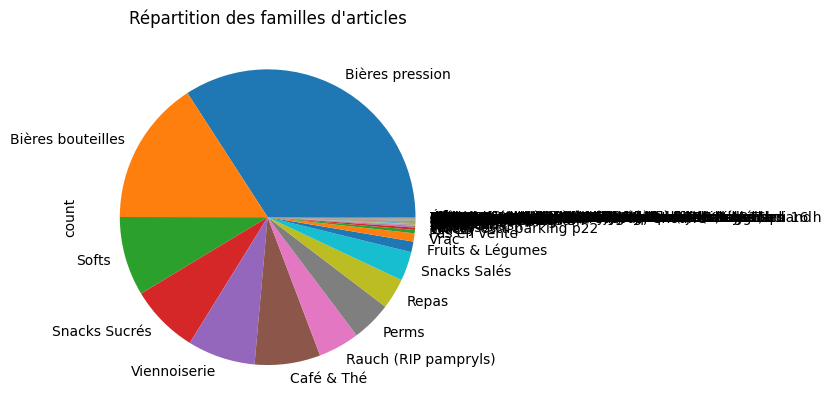

In [40]:
print("Nombre de familles d'articles : ", df["Famille d'article"].nunique())
print("\nDecompte par valeur : \n")

print(df["Famille d'article"].value_counts())

df["Famille d'article"].value_counts().plot.pie()
plt.title("Répartition des familles d'articles")
plt.show()

In [41]:
df["Famille d'article"].unique()

array(['Viennoiserie', 'Café & Thé', 'Rauch (RIP pampryls)',
       'Snacks Sucrés', 'Softs', 'Snacks Salés', 'Perms', 'Repas',
       'Glacé', 'Bières bouteilles', 'Bières pression',
       'Fruits & Légumes', 'Dégustation Duvel, Maredsous, Chouffe',
       'Dégustation Duvel Maredsous Chouffe', 'Dégustation Saint Médard',
       'Dégustation Val Dieu', 'Dégustation Brasserie des Légendes',
       'Dégustation Kapittel', 'Dégustation Ardwen', 'Dégustation Barbar',
       'Dégustation Délirium', 'Estu Parking', 'pic nic electro',
       'Politesse', 'Menu Oriental', 'Dégustation Lundi 14h',
       'Dégustation de Jeudi 14h - Val Dieu',
       'Dégustation de Lundi 16h - Brasserie Saint Médard',
       'Dégustation de Mercredi 14h - Brasserie Du Bocq',
       'Dégustation de Mardi 16h - Brasserie du Pays Flamand',
       'Dégustation de Lundi 14h - Brasserie des légendes',
       'Dégustation de Mercredi 16h - Brasserie Silly',
       'Dégustation de Mardi 14h - Brouwerij Verhaeghe', 'G

On constate qu'il existe beaucoup de familles d'articles, dont un grand nombre ont peu de données et ne concernent pas des ventes faites par le PIC, mais plutôt à des évènements, tels que des dégustations.

On peut dans un premier temps réduire les données aux familles qui se vendent au pic (ou dont le nom ne permet pas de déduire que la vente n'a pas été faite au pic).

On enlève donc dans un premier temps :
 + les familles de "test" (qui ont sûrement dû être utilisées pour tester le système)
 + les dégustations
 + les ventes par d'autres associations
 + les ventes "Estu"

In [42]:
# familles d'articles à conserver
white_list = {'Viennoiserie', 'Café & Thé', 'Rauch (RIP pampryls)', 'Snacks Sucrés',
                'Softs', 'Snacks Salés', 'Perms', 'Repas', 'Glacé', 'Bières bouteilles',
                'Bières pression', 'Fruits & Légumes', 'pic nic electro', 'Prix unique',
                'Semaine Blanche', 'Pic', 'Les MotherFuckers', 'Profs',
                'Festupic', "Pic'Saoul", 'UTC pour tous', 'FINEPIC', 'Mini Duvel',
                'Battle Smash', 'Pampryls', 'Ébène', 'Poulet', 'Vrac', 'Saucisson', 'Picasso', 'Pic-nique électro',
                'Permanence', 'Perm des grands', 'Assos', 'Chips', 'Céréales', 'PICASSO', 'Pic et pic et collegram',
                'Bières rapides', 'Pic, pic & colegram', 'Ben wins', 'Perm Restauration', 'Pictator - Dime'}

n_before = df.shape[0]

# on filtre les lignes qui ne sont pas dans la white list
df = df[df["Famille d'article"].isin(white_list)]

# On remarque qu'il y a deux catégories pour les pampryls, on les fusionne donc
df["Famille d'article"] = df["Famille d'article"].replace("Rauch (RIP pampryls)", "Pampryls")

n_after = df.shape[0]

print(f"Il reste {n_after/n_before*100:.2f}% des données par rapport à l'étape d'avant après suppression des familles d'articles non pertinentes.")


Il reste 98.91% des données par rapport à l'étape d'avant après suppression des familles d'articles non pertinentes.


Nous avons ainsi réduit le nombre de familles en enlevant celles dont la non appartenance au pic
était évidente, mais parmi les familles que nous avons conservées, il en reste probablement qui ne sont pas vendues au pic.

Nous allons donc nous servir du fait que la majorité des données dont nous possédons concernent des ventes du pic, et nous allons utiliser la fréquence d'apparition de chaque famille pour déterminer si elle est vendue au pic ou si elle concerne un évènement isolé.

On peut par exemple les trier les famille fréquence d'apparition et observer le comportement lorsque l'on ne considère que les N familles les plus fréquentes.

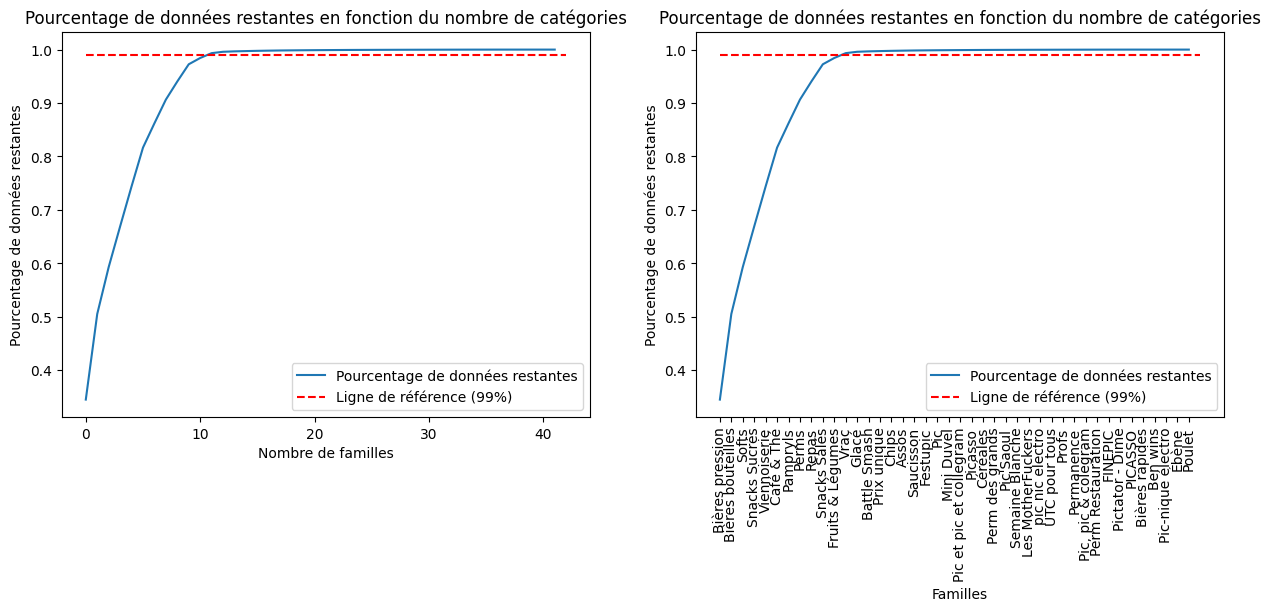

In [43]:
n_data = df.shape[0]

values_counts = df["Famille d'article"].value_counts()
cumul_ratio = values_counts.cumsum() / n_data
indexes = [i for i in range(len(cumul_ratio))]

# familles triées par ordre décroissant de nombre d'articles
familles = df["Famille d'article"].value_counts().index


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(indexes, cumul_ratio)
ax1.plot([0, len(cumul_ratio)], [0.99, 0.99], color='red', linestyle='--')
ax1.set_title("Pourcentage de données restantes en fonction du nombre de catégories")
ax1.set_xlabel("Nombre de familles") # Légende de l'axe des x
ax1.set_ylabel("Pourcentage de données restantes") # Légende de l'axe des y
ax1.legend(["Pourcentage de données restantes", "Ligne de référence (99%)"]) # Légende des courbes

ax2.plot(indexes, cumul_ratio)
ax2.plot([0, len(cumul_ratio)], [0.99, 0.99], color='red', linestyle='--')
ax2.set_xticks(range(len(cumul_ratio)), familles, rotation=90)
ax2.set_title("Pourcentage de données restantes en fonction du nombre de catégories")
ax2.set_xlabel("Familles") # Légende de l'axe des x
ax2.set_ylabel("Pourcentage de données restantes") # Légende de l'axe des y
ax2.legend(["Pourcentage de données restantes", "Ligne de référence (99%)"]) # Légende des courbes

plt.show()

On peut voir qu'il suffit de prendre les ~10 familles les plus fréquentes sur la quarantaine qu'il nous reste pour avoir la majorité (99%) des données. On va donc conserver les N familles les plus fréquentes de sorte à avoir 99% des données.

Cette méthode enlèvera également des familles qui ont été vendues au pic par le passé, telles que les "glacés" (barres chocolatées glacées), mais ces données sont trop peu nombreuses pour être utilisables.

In [44]:
n_data = df.shape[0]
values_counts = df["Famille d'article"].value_counts()
cumul_ratio = values_counts.cumsum() / n_data

n_familles_garder = cumul_ratio[cumul_ratio < 0.99].shape[0] + 1
familles_garder = df["Famille d'article"].value_counts().index[:n_familles_garder]

df = df[df["Famille d'article"].isin(familles_garder)]

print(f"Nous avons conservé {n_familles_garder} familles.")


Nous avons conservé 12 familles.


On peut afficher à nouveau nos données sous forme de camembert pour observer la répartition des familles d'articles restantes :

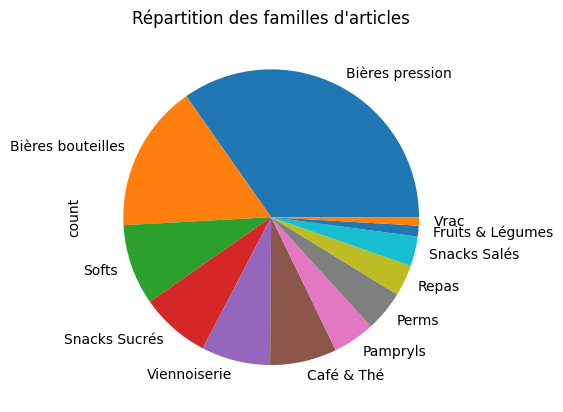

In [45]:
df["Famille d'article"].value_counts().plot.pie()
plt.title("Répartition des familles d'articles")
plt.show()

Les familles restantes ont toutes l'air cohérentes avec les ventes du Pic, avec une exception un peu floue, "Perms". On va donc explorer les articles de cette famille d'articles.

["Pâtes carbo - En'K'dance" "Pâtes SANS GATEAU - En'K'dance"
 "Menu - Vin'tage" ... 'sandwich pompom - Pompom'
 'Menu Noblesse - Pictator' 'Menu du pauvre - Pictator']


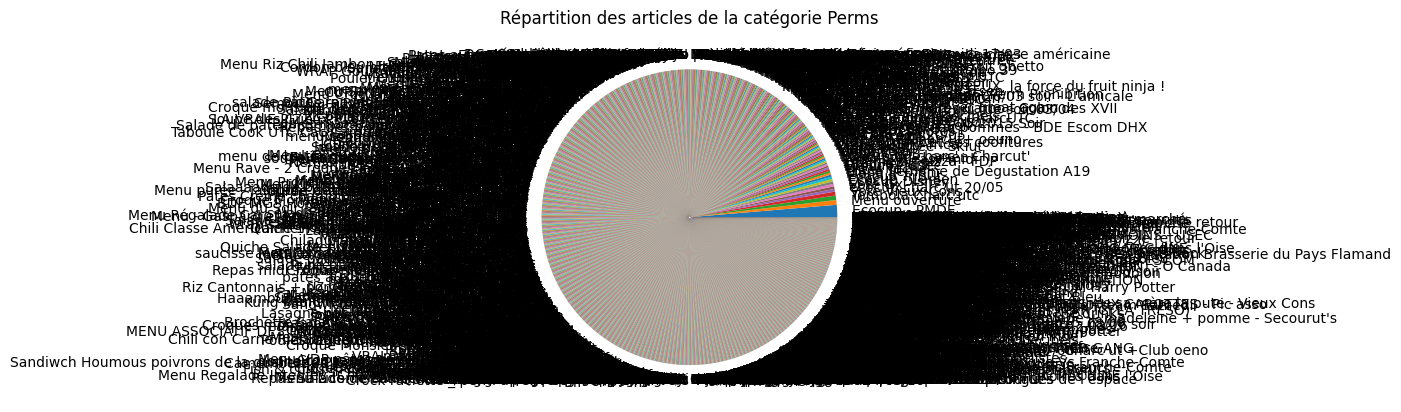

In [46]:
print(df[df['Famille d\'article'] == 'Perms']['Article'].unique())

# pie chart
df[df['Famille d\'article'] == 'Perms']['Article'].value_counts().plot.pie()
plt.title("Répartition des articles de la catégorie Perms")
plt.show()

La famille "Perms" est visiblement remplie d'articles qui ont été vendues a des permanences spécifiques, et très peu de fois, ces données ne sont donc pas représentatives des ventes habituelles du pic et chaque article est en trop petite quantité pour être exploité. On va donc supprimer cette famille d'articles.

On peut également fusionner les deux catégories de bière.

In [47]:
df = df[df['Famille d\'article'] != 'Perms']

df["Famille d'article"] = df["Famille d'article"].replace("Bières bouteilles", "Bieres")
df["Famille d'article"] = df["Famille d'article"].replace("Bières pression", "Bieres")

Nombre de familles d'articles :  10

   Decompte par valeur : 

Famille d'article
Bieres              965980
Softs               167555
Snacks Sucrés       145527
Viennoiserie        143213
Café & Thé          138805
Pampryls             87032
Repas                64921
Snacks Salés         61535
Fruits & Légumes     22447
Vrac                 17372
Name: count, dtype: int64


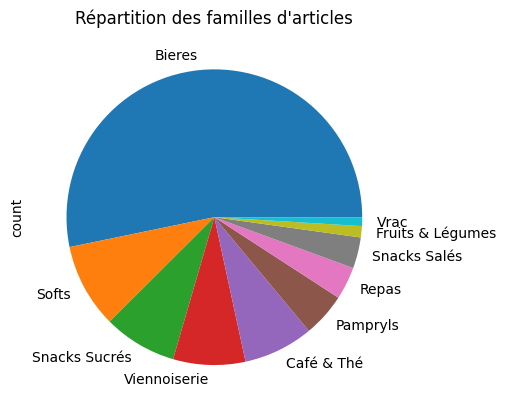

In [48]:
print("Nombre de familles d'articles : ", df["Famille d'article"].nunique())
print("\n   Decompte par valeur : \n")

print(df["Famille d'article"].value_counts())

df["Famille d'article"].value_counts().plot.pie()
plt.title("Répartition des familles d'articles")
plt.show()

Le traitement des familles d'articles est maintenant terminé.

# 3. Traitement des articles

Articles :  791

   Decompte par valeur : 

Article
Delirium Tremens                         138026
Café                                     126580
Cuvée des Trolls                         114614
Barbar Blonde                             62293
Gauloise Rouge                            51551
                                          ...  
Baby Carottes                                 1
Saucisson Charc'UT - Myrtille                 1
NE PAS SUPPRIMER - Vin Chaud Téléthon         1
Menu Greg                                     1
Gobelet Eau                                   1
Name: count, Length: 791, dtype: int64


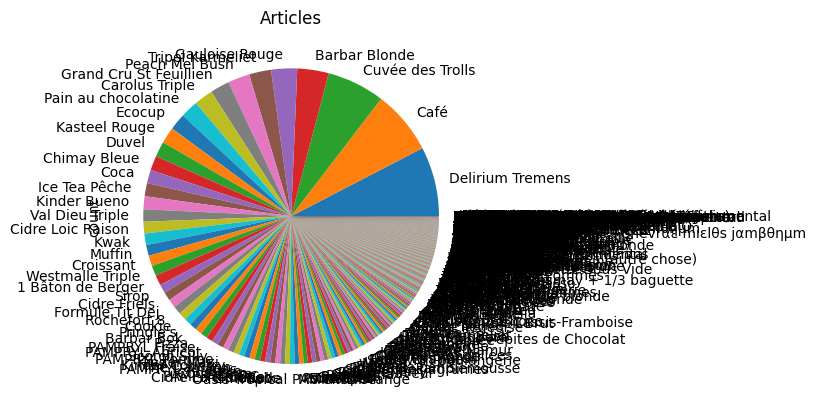

In [49]:
print("Articles : ", df["Article"].nunique())
print("\n   Decompte par valeur : \n")

print(df["Article"].value_counts())

df["Article"].value_counts().plot.pie()
plt.title("Articles")
plt.show()

Il y a beaucoup d'articles différent donc un grand nombre n'est presque pas représenté. On peut essayer de supprimer les articles les moins fréquents et voir combien on arrive à en supprimer si on veut garder 99% des données.

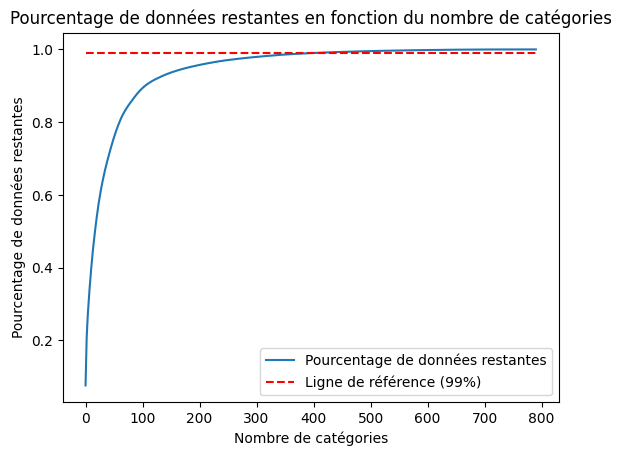

In [50]:
n_data = df.shape[0]

values_counts = df["Article"].value_counts()
cumul_ratio = values_counts.cumsum() / n_data
indexes = [i for i in range(len(cumul_ratio))]

plt.plot(indexes, cumul_ratio)
plt.plot([0, len(cumul_ratio)], [0.99, 0.99], color='red', linestyle='--')
plt.title("Pourcentage de données restantes en fonction du nombre de catégories")
plt.xlabel("Nombre de catégories") # Légende de l'axe des x
plt.ylabel("Pourcentage de données restantes") # Légende de l'axe des y
plt.legend(["Pourcentage de données restantes", "Ligne de référence (99%)"]) # Légende des courbes

plt.show()

On constate qu'en conservant environ la moitié des articles (ceux qui sont les plus fréquents), on conserve 99% des données.

In [51]:
n_data = df.shape[0]
values_counts = df["Article"].value_counts()
cumul_ratio = values_counts.cumsum() / n_data

n_articles_garder = cumul_ratio[cumul_ratio < 0.99].shape[0] + 1
articles_garder = df["Article"].value_counts().index[:n_articles_garder]

df = df[df["Article"].isin(articles_garder)]

print(f"Nous avons conservé {n_articles_garder} articles.")


Nous avons conservé 398 articles.


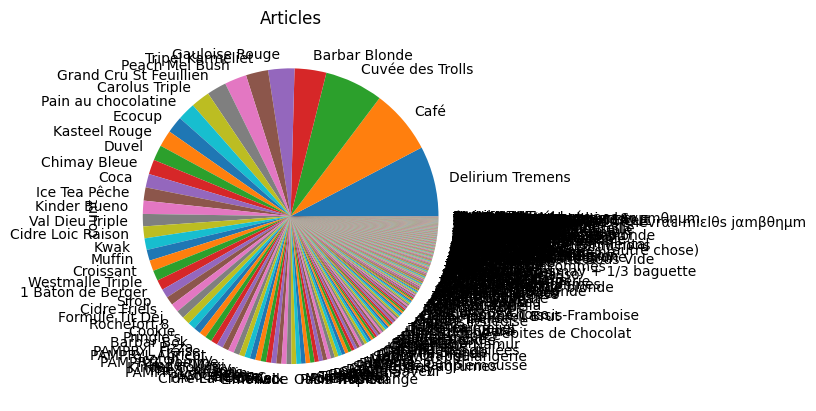

In [52]:
df["Article"].value_counts().plot.pie()
plt.title("Articles")
plt.show()

On peut voir que parmis les ventes se trouvent des ecocups (les consignes probablement),
ces "ventes" ne sont pas pertinentes pour notre étude, on va donc les supprimer.

In [53]:
df = df[df["Article"].str.contains("Ecocup") == False]
df = df[df["Article"].str.contains("ecocup") == False]

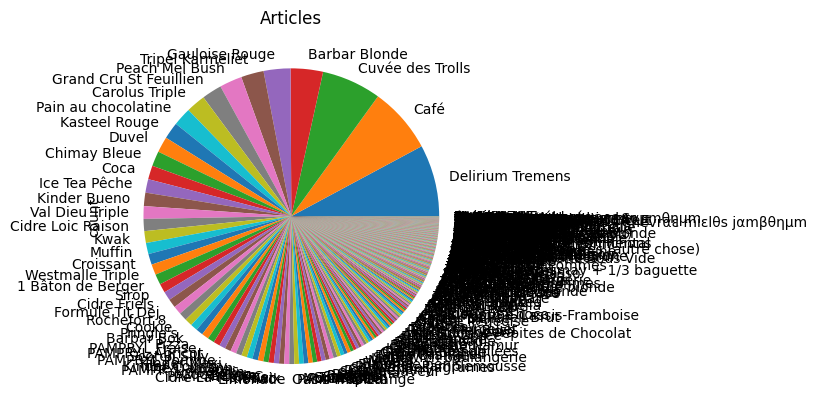

In [54]:
df["Article"].value_counts().plot.pie()
plt.title("Articles")
plt.show()

La liste a bien réduit mais il y a encore beaucoup d'articles à fusionner car ayant la même signification, "Seven up bouteille" et "7up" par exemple. Suite à une analyse manuelle, nous allons donc fusionner ces articles.

In [55]:
# on met en minuscule le nom des articles, car certains noms sont identiques, aux majuscules près
df["Article"] = df["Article"].str.lower()

# on retire les accents des articles, car certains noms sont identiques, aux accents près
accents = ["é", "è", "ê", "ë"]
for accent in accents:
    df["Article"] = df["Article"].str.replace(accent, "e")

In [56]:
# suppression d'articles
df = df[df["Article"] != "if **silly rouge**"]
df = df[df["Article"] != "vert"]
df = df[df["Article"] != "rouge"]
df = df[df["Article"] != "jaune"]
df = df[df["Article"] != "bleu"]
df = df[df["Article"] != "courant"]
df = df[df["Article"] != "1/4 fromage chimay"]
df = df[df["Article"] != "1/4 fromage chimay + 1/3 baguette"]
df = df[df["Article"] != "sandwich invendu"]

# fusion d'articles
## avec regex
df["Article"] = df["Article"].str.replace("val dieu triple.*", "val dieu triple", regex=True)
df["Article"] = df["Article"].str.replace("val dieu grand cru.*", "val dieu grand cru", regex=True)
df["Article"] = df["Article"].str.replace("coca.*", "coca", regex=True)
df["Article"] = df["Article"].str.replace(".*pring.*", "pringles", regex=True)
df["Article"] = df["Article"].str.replace("peche mel bush.*", "peche mel bush", regex=True)
df["Article"] = df["Article"].str.replace("kinder.*", "kinder", regex=True)
df["Article"] = df["Article"].str.replace(".*chouffe.*", "chouffe", regex=True)
df["Article"] = df["Article"].str.replace(".*up .*", "7up", regex=True)
df["Article"] = df["Article"].str.replace("jus orange.*", "jus orange", regex=True)
df["Article"] = df["Article"].str.replace("sandwich.*", "sandwich", regex=True)
df["Article"] = df["Article"].str.replace("biscuit.*", "biscuit", regex=True)
df["Article"] = df["Article"].str.replace("straffe .*", "straffe hendrik", regex=True)
df["Article"] = df["Article"].str.replace("duvel .*", "duvel", regex=True)
df["Article"] = df["Article"].str.replace("barbar .*", "barbar", regex=True)
df["Article"] = df["Article"].str.replace("cookie .*", "cookie", regex=True)
df["Article"] = df["Article"].str.replace(".*belin.*", "belin", regex=True)
df["Article"] = df["Article"].str.replace("kit kat .*", "kit kat", regex=True)
df["Article"] = df["Article"].str.replace(".*nouille.*", "nouille", regex=True)
df["Article"] = df["Article"].str.replace(".*saucisson.*", "saucisson", regex=True)
df["Article"] = df["Article"].str.replace(".*viennoiserie.*", "suisse", regex=True)
df["Article"] = df["Article"].str.replace(".*repas.*", "repas", regex=True)
df["Article"] = df["Article"].str.replace(".*hop's.*", "ardwen hop's cure", regex=True)
df["Article"] = df["Article"].str.replace("biere.*hasard", "biere hasard", regex=True)
df["Article"] = df["Article"].str.replace(".*haribo.*", "haribo", regex=True)
df["Article"] = df["Article"].str.replace(".*divine", "la divine", regex=True)
df["Article"] = df["Article"].str.replace(".*troll.*", "cuvee des trolls", regex=True)

## sans regex
df["Article"] = df["Article"].str.replace("saxo", "jus")
df["Article"] = df["Article"].str.replace("rauch", "jus")
df["Article"] = df["Article"].str.replace("pampryl", "jus")
df["Article"] = df["Article"].str.replace("jus oac", "jus ace")
df["Article"] = df["Article"].str.replace("valdieu triple", "val dieu triple")
df["Article"] = df["Article"].str.replace("cheese burger", "burger")
df["Article"] = df["Article"].str.replace("triple lefort", "lefort triple")
df["Article"] = df["Article"].str.replace("la poire", "poire")
df["Article"] = df["Article"].str.replace("the lipton", "ice tea pêche")
df["Article"] = df["Article"].str.replace("fuze tea", "ice tea pêche")
df["Article"] = df["Article"].str.replace("roule au nutella", "roule nutella")
df["Article"] = df["Article"].str.replace("bush 10", "bush ambree")
df["Article"] = df["Article"].str.replace("coeur orange", "orange")
df["Article"] = df["Article"].str.replace("orange pavot", "orange")
df["Article"] = df["Article"].str.replace("chips naten bio", "chips")
df["Article"] = df["Article"].str.replace("pepsi bouteille", "coca")
df["Article"] = df["Article"].str.replace("tripel karmeliet", "triple karmeliet")
df["Article"] = df["Article"].str.replace("jus pampl.", "jus pamplemousse", regex=False)
df["Article"] = df["Article"].str.replace("peach mel bush", "peche mel bush")


In [57]:
print(f"Nombre d'articles : {df['Article'].nunique()}")

Nombre d'articles : 274


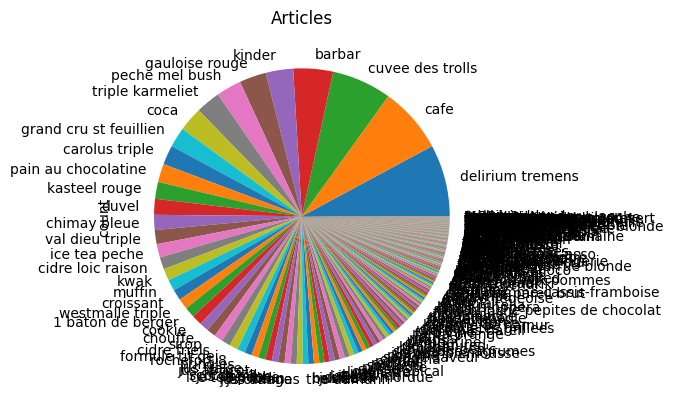

In [58]:
df["Article"].value_counts().plot.pie()
plt.title("Articles")
plt.show()

In [59]:
print(f"Total gardé par rapport au début : {df.shape[0]/nombre_donnees_initial*100:.2f}%")

Total gardé par rapport au début : 88.10%


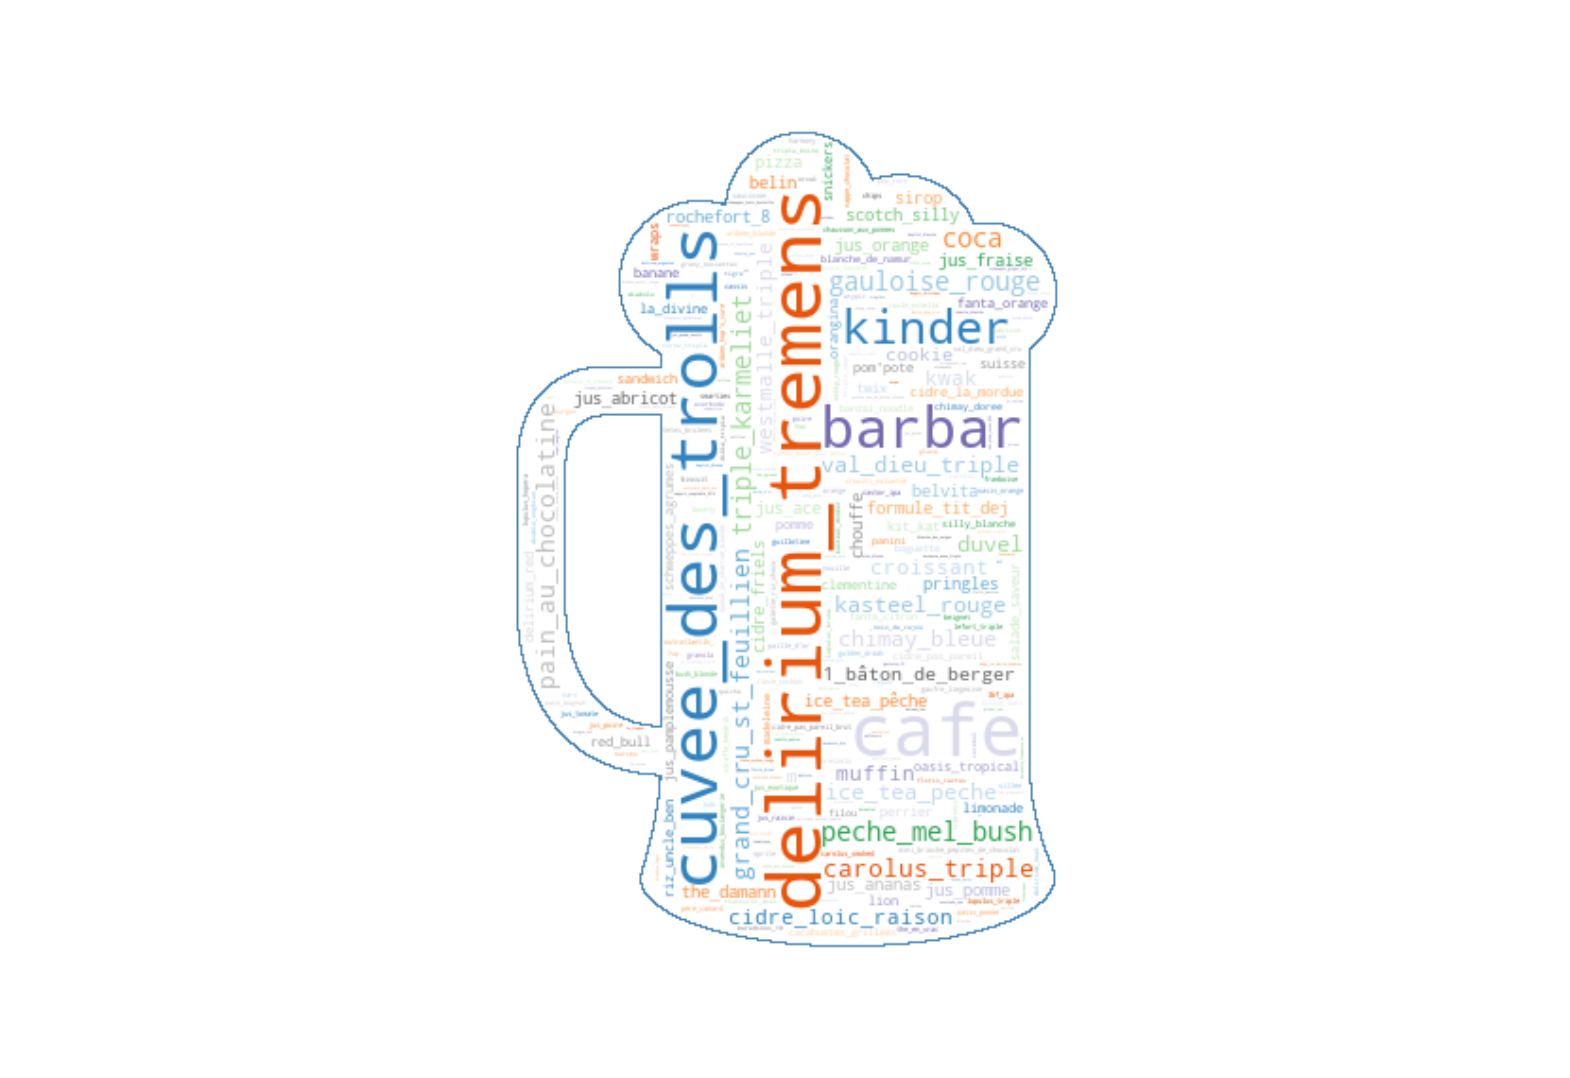

In [92]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# On remplace les espaces des articles par _ 
df["Article"] = df["Article"].str.replace(" ", "_")


# On crée un string avec tous les articles
articles = ' '.join(df["Article"])

# On crée le wordcloud
shape_mask = np.array(Image.open("beer_test.png").convert('L'))

# Appliquer un seuil pour obtenir une image en noir et blanc
threshold = 127  # Seuil, ajustez cette valeur selon vos besoins
shape_mask = np.where(shape_mask > threshold, 255, 0).astype(np.uint8)


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='tab20c',
    collocations=False,
    max_font_size=40,
    min_font_size=1,
    contour_width=1,
    contour_color='steelblue',
    max_words=274,
    mask=shape_mask
).generate(articles)

contour = np.zeros(shape_mask.shape, dtype=np.uint8)
contour[shape_mask == 0] = 255
contour = np.logical_not(contour)

# On l'affiche
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
#plt.imshow(contour, cmap='gray', interpolation='bilinear', alpha=0.5)
plt.axis("off")
plt.show()